### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1) MSE:  $ \displaystyle \frac{dL(a(x_i), y_i)}{da(x_i)} = 2(y_i - a(x_i))$
2) exp:  $ \displaystyle \frac{dL(a(x_i), y_i)}{da(x_i)} = y_iexp(-a(x_i)y_i)$
3) log:  $ \displaystyle \frac{dL(a(x_i), y_i)}{da(x_i)} = \frac{y_i}{exp(a(x_i)y_i) + 1}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [27]:
class ConstModel:
    
    def __init__(self, value):
        self.value = value
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return np.full(X.shape[0], self.value)
    

class MyGradientBoostingClassifier:

    def __init__(self, loss, learning_rate, n_estimators, colsample, subsample, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.kwargs = kwargs
        self.models = []
        if loss == "MSE": # поиск нового шага совпадает с задачей линейной регрессии, где
                          # ответы новой модели должны описать ошибки всей предшествующей
            self.calc_grad = lambda a, y: 2 * (y - a)
            self.calc_step = lambda new, error: LinearRegression(fit_intercept=False).fit(new.reshape(-1, 1), error).coef_[0]
        elif loss == "exp":
            self.calc_grad = lambda a, y: y * np.exp(-(a * y))
            self.calc_step = lambda new, error: 1
        elif loss == "log":
            self.calc_grad = lambda a, y: y / (1 + np.exp(a * y))
            self.calc_step = lambda new, error: 1
        else:
            raise NameError(f"Bad loss name: {self.loss}")
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        if init_model:
            self.models.append((init_model(), 1, np.arange(X.shape[1])))
            self.models[0][0].fit(X, y)
        else:
            self.models.append((ConstModel(0), 1, np.arange(X.shape[1])))
        if self.kwargs:
            get_new_model = lambda : base_model(**self.kwargs)
        else:
            get_new_model = base_model
        n_obj = int(X.shape[0] * self.subsample)
        n_feat = int(X.shape[1] * self.colsample)
        for i in range(self.n_estimators):
            new_model = get_new_model()
            obj_idx = np.random.choice(X.shape[0], size=n_obj, replace=False)
            feat_idx = np.random.choice(X.shape[1], size=n_feat, replace=False)
            cut_obj_X = X[obj_idx, :]
            cut_obj_y = y[obj_idx]
            old_prediction = self.predict(cut_obj_X)
            target = self.learning_rate * self.calc_grad(old_prediction, cut_obj_y)
            full_cut_X = cut_obj_X[:, feat_idx]
            new_model.fit(full_cut_X, cut_obj_y)
            new_prediction = new_model.predict(X[:, feat_idx])
            old_prediction = self.predict(X)
            step = self.calc_step(new_prediction, y - old_prediction)
            self.models.append((new_model, step, feat_idx))
        return self
    
    def predict(self, X):
        ans = np.zeros(X.shape[0])
        for item in self.models:
            ans = ans + item[1] * item[0].predict(X[:, item[2]])
        return np.around(ans)


In [3]:
my_clf = MyGradientBoostingClassifier(
    loss="MSE", learning_rate=0.1, n_estimators=10, colsample=1, subsample=1)
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GroupKFold, cross_val_score
from tqdm import tqdm
from sklearn.metrics import accuracy_score
X, y = fetch_california_housing(return_X_y=True)

In [8]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [15]:
n_estimators_list = [10, 50, 100, 200, 500, 1000, 1500] 
test_scores = []
train_scores = []

for n_est in tqdm(n_estimators_list):
    clf = MyGradientBoostingClassifier(
                loss="MSE", learning_rate=0.1,
                n_estimators=n_est, colsample=1, subsample=1
    )
    
    train_score = accuracy_score(
        y_train, clf.fit(X_train, y_train).predict(X_train)
    )
    train_scores.append(train_score)
    test_score = accuracy_score(
        y_test, clf.predict(X_test)
    )
    test_scores.append(test_score)

 86%|█████████████████████████████████████▋      | 6/7 [39:08<06:31, 391.38s/it]


KeyboardInterrupt: 

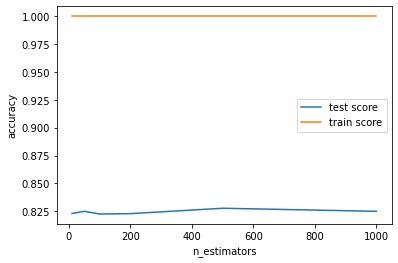

In [16]:
import matplotlib.pyplot as plt 

plt.plot(n_estimators_list[:-1], test_scores, label='test score')
plt.plot(n_estimators_list[:-1], train_scores, label='train score')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [23]:
learn_rates = [1, 0.1, 0.05, 0.01, 0.005, 0.001]
test_scores = []
train_scores = []

for learn_rate in tqdm(learn_rates):
    clf = MyGradientBoostingClassifier(
                loss="MSE", learning_rate=learn_rate,
                n_estimators=50, colsample=1, subsample=1,
                max_depth=4
    )
    
    train_score = accuracy_score(
        y_train, clf.fit(X_train, y_train).predict(X_train)
    )
    train_scores.append(train_score)
    test_score = accuracy_score(
        y_test, clf.predict(X_test)
    )
    test_scores.append(test_score)

100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.69s/it]


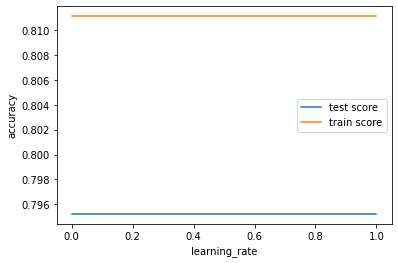

In [24]:
import matplotlib.pyplot as plt 

plt.plot(learn_rates, test_scores, label='test score')
plt.plot(learn_rates, train_scores, label='train score')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [35]:
colsamples = [i/20 for i in range(6, 21)]
test_scores = []
train_scores = []

for colsample in tqdm(colsamples):
    clf = MyGradientBoostingClassifier(
                loss="MSE", learning_rate=0.1,
                n_estimators=50, colsample=colsample, subsample=1,
                max_depth=4
    )
    
    train_score = accuracy_score(
        y_train, clf.fit(X_train, y_train).predict(X_train)
    )
    train_scores.append(train_score)
    test_score = accuracy_score(
        y_test, clf.predict(X_test)
    )
    test_scores.append(test_score)

100%|███████████████████████████████████████████| 15/15 [00:38<00:00,  2.56s/it]


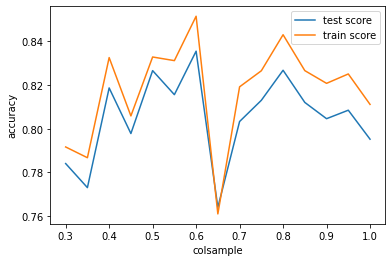

In [36]:
plt.plot(colsamples, test_scores, label='test score')
plt.plot(colsamples, train_scores, label='train score')
plt.xlabel('colsample')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [37]:
subsamples = [i/20 for i in range(6, 21)]
test_scores = []
train_scores = []

for subsample in tqdm(subsamples):
    clf = MyGradientBoostingClassifier(
                loss="MSE", learning_rate=0.1,
                n_estimators=50, colsample=0.6, subsample=subsample,
                max_depth=4
    )
    
    train_score = accuracy_score(
        y_train, clf.fit(X_train, y_train).predict(X_train)
    )
    train_scores.append(train_score)
    test_score = accuracy_score(
        y_test, clf.predict(X_test)
    )
    test_scores.append(test_score)

100%|███████████████████████████████████████████| 15/15 [00:27<00:00,  1.85s/it]


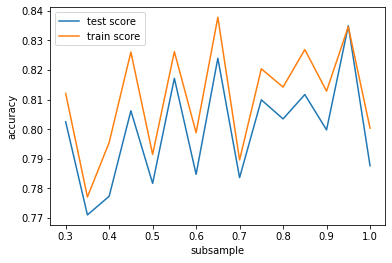

In [38]:
plt.plot(subsamples, test_scores, label='test score')
plt.plot(subsamples, train_scores, label='train score')
plt.xlabel('subsample')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [40]:
depths = [i for i in range(1, 10)]
test_scores = []
train_scores = []

for depth in tqdm(depths):
    clf = MyGradientBoostingClassifier(
                loss="MSE", learning_rate=0.1,
                n_estimators=50, colsample=0.6, subsample=0.95,
                max_depth=depth
    )
    
    train_score = accuracy_score(
        y_train, clf.fit(X_train, y_train).predict(X_train)
    )
    train_scores.append(train_score)
    test_score = accuracy_score(
        y_test, clf.predict(X_test)
    )
    test_scores.append(test_score)

100%|█████████████████████████████████████████████| 9/9 [00:24<00:00,  2.72s/it]


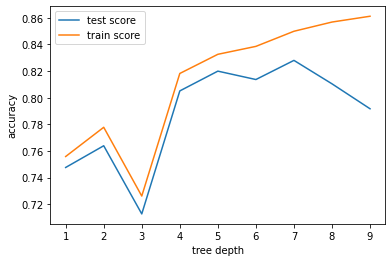

In [41]:
plt.plot(depths, test_scores, label='test score')
plt.plot(depths, train_scores, label='train score')
plt.xlabel('tree depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Лучшие параметры:
                loss="MSE", learning_rate=0.1,
                n_estimators=50, colsample=0.6, subsample=0.95,
                max_depth=7
                
Лучшая accuracy на тесте: 0.83

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
clf = MyGradientBoostingClassifier(
                loss="MSE", learning_rate=0.1,
                n_estimators=50, colsample=0.6, subsample=0.95,
                max_depth=7
    )
clf.fit(X_train, y_train, base_model=RandomForestClassifier)
accuracy_score(y_test, clf.predict(X_test))

0.854812661498708

Качество улучшилось из-за дополнительного уровня бутстрепирования

In [54]:
clfs = []
predictions = []
for i in tqdm(range(10)):
    obj_idx = np.random.choice(X_train.shape[0], size=X_train.shape[0] // 2, replace=False)
    cut_obj_X = X_train[obj_idx, :]
    cut_obj_y = y_train[obj_idx]
    clf = MyGradientBoostingClassifier(
                    loss="MSE", learning_rate=0.1,
                    n_estimators=50, colsample=0.6, subsample=0.95,
                    max_depth=7
        )
    clf.fit(cut_obj_X, cut_obj_y)
    predictions.append(clf.predict(X_test))

100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


In [62]:
predictions = np.array(predictions)
ans = np.mean(predictions, axis=0) > 0.5
ans.astype(int)
accuracy_score(y_test, ans)

0.8653100775193798

Качество еще улучшилось по той же причине

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC

In [67]:
init_models = [LinearRegression, LinearSVC, RandomForestClassifier]
test_scores = []
train_scores = []

for init_model in tqdm(init_models):
    clf = MyGradientBoostingClassifier(
                loss="MSE", learning_rate=0.1,
                n_estimators=50, colsample=0.6, subsample=0.95,
                max_depth=7
    )
    
    train_score = accuracy_score(
        y_train, clf.fit(X_train, y_train, init_model=init_model).predict(X_train)
    )
    train_scores.append(train_score)
    test_score = accuracy_score(
        y_test, clf.predict(X_test)
    )
    test_scores.append(test_score)

 33%|███████████████                              | 1/3 [00:05<00:11,  5.78s/it]/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
100%|█████████████████████████████████████████████| 3/3 [00:33<00:00, 11.22s/it]


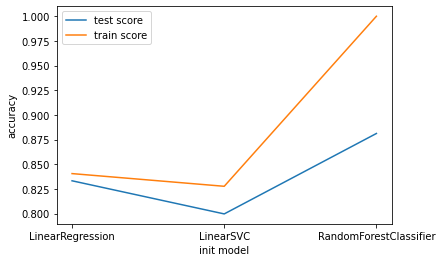

In [69]:
plt.plot(["LinearRegression", "LinearSVC", "RandomForestClassifier"], test_scores, label='test score')
plt.plot(["LinearRegression", "LinearSVC", "RandomForestClassifier"], train_scores, label='train score')
plt.xlabel('init model')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Сильно улучшилось качество на случайном лесе, наверное из-за его однородности с деревьями

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

